<a href="https://colab.research.google.com/github/i-m-himanshu/BERT-vs-GAN-BERT/blob/main/GAN-BERT/GAN_implementation4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Experimental Settings

In [ ]:
import time

# training dataset
labeled_data_size = 350 #this was initially 100
unlabeled_data_size = 350 #this was initially 100

# training hyperparameter
num_train_epochs = 10

# dict_settings
dict_settings = {
    'labeled_data_size':labeled_data_size,
    'unlabeld_data_size':unlabeled_data_size,
    'num_train_epochs':num_train_epochs
}

print(dict_settings)

entire_notebook_t0 = time.time()#??

{'labeled_data_size': 350, 'unlabeld_data_size': 350, 'num_train_epochs': 10}


#Using GPU

In [ ]:
%tensorflow_version 2.x

import tensorflow as tf
print(tf.__version__)
print(tf.test.gpu_device_name())
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2.8.0
/device:GPU:0
Num GPUs Available:  1


In [ ]:
import torch

#The assert keyword is used when debugging code. The assert keyword lets you test if a condition in your code returns True, if not, the program will raise an AssertionError.
assert torch.cuda.is_available()

# Tell torch to use GPU
device = torch.device("cuda")
print('Running GPU: {}'.format(torch.cuda.get_device_name()))

Running GPU: Tesla T4


In [ ]:
# import essential modules
import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

import random
import numpy as np
import pandas as pd

import time
import math
import datetime

In [ ]:
# Set random seed
#The seed value is a base value used by a pseudo-random generator to produce random numbers.
seed = 1

#The random number or data generated by Python's random module is not truly random; it is pseudo-random(it is PRNG), i.e., deterministic. The random module uses the seed value as a base to generate a random number.
#By setting the custom seed value, we can reproduce the data given by a pseudo-random number generator. Choose the same elements from the list randomly every time using random.seed()
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

#Prepare Dataset

Matplotlib vs Seaborn
1.   Matplotlib: It is a Python library used for plotting graphs with the help of other libraries like Numpy and Pandas. It is a powerful tool for visualizing data in Python. It is used for creating statical interferences and plotting 2D graphs of arrays.
2.   Seaborn: It is also a Python library used for plotting graphs with the help of Matplotlib, Pandas, and Numpy. It is built on the roof of Matplotlib and is considered as a superset of the Matplotlib library. It helps in visualizing univariate and bivariate data. It uses beautiful themes for decorating Matplotlib graphics. It acts as an important tool in picturing Linear Regression Models. It eliminates the overlapping of graphs and also aids in their beautification.

Number of different classes: 6


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


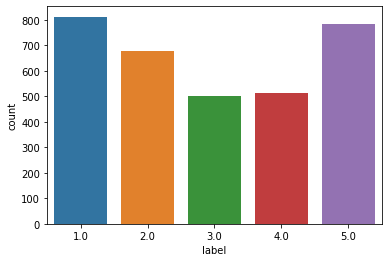

In [ ]:
# Load training dataset
df = pd.read_csv('Dataset4_train(ganbert)2.csv')

# Mapping the class to label code
# Label Encdoing: Label Encoding refers to converting the labels into a numeric form so as to convert them into the machine-readable form. Machine learning algorithms can then decide in a better way how those labels must be operated. It is an important pre-processing step for the structured dataset in supervised learning.
class_map={'UNK':0, 'neutral':1, 'sadness':2, 'fear':3, 'anger':4, 'joy':5}

# Show number of different classes
n_classes = len(class_map)
print('Number of different classes: {}'.format(n_classes))

# Mapping the class names
#'review' and 'sentiment' are two columns names present in our dataset
df["label"] = df["label"].map(class_map)

# Show class countplot
import seaborn as sns
sns.countplot(df["label"])

In [ ]:
# Initalize the first df
#We have already defined the labeled_data_size=100 at the start
df_sampled = df[df['label']==1].sample(labeled_data_size) #We are initializing df_sampled with the 100 data enteries corresponding to sentiment 1 i.e. extremely positive

print(df_sampled) #It will print 100 data enteries corresponding to sentiment 1

# Import samples from the other classes
for i in range(2,6):
    df_temp = df[df['label'] == i].sample(labeled_data_size)
    df_sampled = pd.concat((df_sampled, df_temp))

print(df_sampled) #It will print 100 data enteries corresponding to each sentiment from 1 to 5

                                                   text  label
1818   maybe if I sold my car now , I wouldn't be so...      1
2257                                              oh .       1
3812   I had the same feeling when I first came to w...      1
2850             Thirty minutes in gym at lunch time .       1
2795                                      How was it ?       1
...                                                 ...    ...
3245                                        Go ahead .       1
3235  It is high time you have a talk with him . Tha...      1
2602   It was nice to see you , too.And please give ...      1
1245                                            What ?       1
3797                                       All right .       1

[350 rows x 2 columns]
                                                   text  label
1818   maybe if I sold my car now , I wouldn't be so...      1
2257                                              oh .       1
3812   I had the same feeling w

Number of data entries: 1750


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


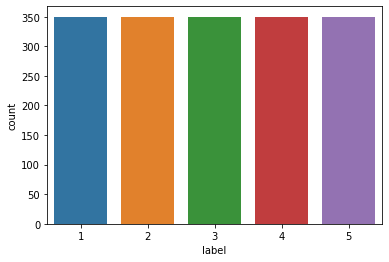

In [ ]:
# Show class countplo
print('Number of data entries: {}'.format(len(df_sampled)))
sns.countplot(df_sampled['label'])

In [ ]:
# Randomly choose 100 data entries which will be converted into unlabled data
df_unlabeled = df.sample(unlabeled_data_size)

# Convert class to UNK
df_unlabeled['label'] = 'UNK'

print(df_unlabeled)

                                                   text label
296                                          See you .    UNK
1372  Tutorial again !  A fearful feeling came to me...   UNK
324   Our only elder sister got married and started ...   UNK
2993  When, for example, I was in my eleventh school...   UNK
3198  Tabitha Campbell-Black was livid because she w...   UNK
...                                                 ...   ...
2792                          When my grandmother died.   UNK
1711                                             Yes .    UNK
2003                                             Jim !    UNK
3095   Well , yes . Several colleagues from differen...   UNK
1168    Again , I do apologize for the inconvenience .    UNK

[350 rows x 2 columns]


In [ ]:
# Split 20% of data from the df_sample as val_data
from sklearn.model_selection import train_test_split

df_labeled, df_val = train_test_split(df_sampled,
                                    test_size=0.2,
                                    random_state=1,
                                    stratify=df_sampled['label'])

for item in df_labeled, df_unlabeled, df_val:
    print(item.shape)

(1400, 2)
(350, 2)
(350, 2)


In [ ]:
! pip install transformers datasets

#Import BERT model

In [ ]:
model_name = "bert-base-cased"

from transformers import BertModel, BertTokenizer

# Load BERT tokenizer
transformer = BertModel.from_pretrained(model_name)
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


#Prepare Dataloader

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'df_val label mask')

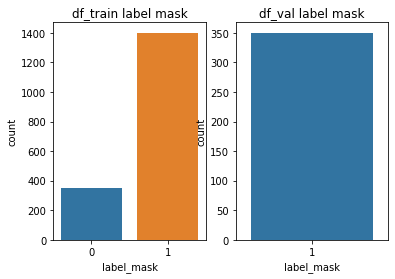

In [ ]:
# Combine df_labeled and df_unlabeled into the train_dataloader
df_train = pd.concat((df_labeled, df_unlabeled))

# Convert UNK to class zero
df_train['label'] = df_train['label'].apply(lambda x: 0 if x=='UNK' else x)

# Create a new column for label_mask
def generate_label_mask(label):
    if label == 0:
        return 0
    else:
        return 1

df_train['label_mask'] = df_train['label'].apply(generate_label_mask)

#The subplot() function takes three arguments that describes the layout of the figure.The layout is organized in rows and columns, which are represented by the first and second argument.The third argument represents the index of the current plot.

# Show label_mask distribution
import matplotlib.pyplot as plt
plt.subplot(1,2,1) #the figure has 1 row, 2 columns, and this plot is the first plot.
sns.countplot(df_train['label_mask'])
plt.title('df_train label mask')

# Generate label mask for df_val
df_val['label_mask'] = df_val['label'].apply(generate_label_mask)

# Show label_mask distribution
plt.subplot(1,2,2) #the figure has 1 row, 2 columns, and this plot is the second plot.
sns.countplot(df_val['label_mask'])
plt.title('df_val label mask')
#1 row means the row with the name 'count' and 2 column means the columns with names 'df_train label mask' and 'df_val label mask' in the plot below
#if we want a figure with 2 rows an 1 column (meaning that the two plots will be displayed on top of each other instead of side-by-side), we can write the syntax like this:
#plt.subplot(2, 1, 1) and plt.subplot(2,1,2) respectively

In [ ]:
# Hyperparameteres
max_length = 128
batch_size = 32

# Tokenization and covnert dataframes to datasets
#A DataFrame is a Dataset organized into named columns
def encode_df(df):
    input_ids = []
    attention_mask = []
    texts = df['text'].values
    labels = df['label'].values
    label_masks = df['label_mask'].values
    
    for text in texts:
        encoded_dict = tokenizer.encode_plus(text,
                                             add_special_tokens=True,
                                             padding='max_length',
                                             return_attention_mask=True,
                                             max_length=max_length,
                                             return_tensors='pt',
                                             truncation=True)
        
        input_ids.append(encoded_dict['input_ids'])
        attention_mask.append(encoded_dict['attention_mask'])
    
    return input_ids, attention_mask, labels, label_masks

In [ ]:
# Concat input_ds and attention_mask
def concat_data(input_ids, attention_mask, labels, label_masks):
    input_ids = torch.cat(input_ids, dim=0)
    attention_mask = torch.cat(attention_mask, dim=0)
    labels = torch.tensor(labels)
    label_masks = torch.tensor(label_masks)
    
    return input_ids, attention_mask, labels, label_masks

In [ ]:
# Convert encoded data to dataset
def make_dataloader(input_ids, attention_mask, labels, label_masks, random_sampler=True):
    temp_dataset = TensorDataset(input_ids, attention_mask, labels, label_masks)
    
    if random_sampler:
        dataloader = DataLoader(temp_dataset,
                                batch_size=batch_size,
                                sampler=RandomSampler(temp_dataset))

    else:
        dataloader = DataLoader(temp_dataset,
                                batch_size=batch_size,
                                sampler=SequentialSampler(temp_dataset))
    
    return dataloader

In [ ]:
# Convert df_labeled, df_unlabeled, df_val to dataloader

#df_labeled
input_ids, attention_mask, labels, label_masks = encode_df(df_train)
input_ids, attention_mask, labels, label_masks = concat_data(input_ids, attention_mask, labels, label_masks)
train_dataloader = make_dataloader(input_ids, attention_mask, labels, label_masks, random_sampler=True)

#df_val
input_ids, attention_mask, labels, label_masks = encode_df(df_val)
input_ids, attention_mask, labels, label_masks = concat_data(input_ids, attention_mask, labels, label_masks)
test_dataloader = make_dataloader(input_ids, attention_mask, labels, label_masks, random_sampler=False)

#Set up the Models

In [ ]:
# Hyperparameters
noise_size = 100
drate = 0.2

# Replicate labeled data to balance poorly represented datasets, 
# e.g., less than 1% of labeled material
#apply_balance = True

In [ ]:
from torch.nn import Module, Linear, LeakyReLU, Dropout, Sequential, Softmax
import torch.nn.functional as F

class Generator(nn.Module):
    def __init__(self, noise_size=100, output_size=512, hidden_sizes=[512], dropout_rate=0.1):
        super(Generator, self).__init__()
        layers = []
        hidden_sizes = [noise_size] + hidden_sizes
        for i in range(len(hidden_sizes)-1):
            layers.extend([nn.Linear(hidden_sizes[i], hidden_sizes[i+1]), nn.LeakyReLU(0.2, inplace=True), nn.Dropout(dropout_rate)])

        layers.append(nn.Linear(hidden_sizes[-1],output_size))
        self.layers = nn.Sequential(*layers)

    def forward(self, noise):
        output_rep = self.layers(noise)
        return output_rep

class Discriminator(nn.Module):
    def __init__(self, input_size=512, hidden_sizes=[512], num_labels=2, dropout_rate=0.1):
        super(Discriminator, self).__init__()
        self.input_dropout = nn.Dropout(p=dropout_rate)
        layers = []
        hidden_sizes = [input_size] + hidden_sizes
        for i in range(len(hidden_sizes)-1):
            layers.extend([nn.Linear(hidden_sizes[i], hidden_sizes[i+1]), nn.LeakyReLU(0.2, inplace=True), nn.Dropout(dropout_rate)])
        
        self.layers = nn.Sequential(*layers) #per il flatten
        self.logit = nn.Linear(hidden_sizes[-1],num_labels+1) # +1 for the probability of this sample being fake/real.
        self.softmax = nn.Softmax(dim=-1)
    
    def forward(self, input_rep):
        input_rep = self.input_dropout(input_rep)
        last_rep = self.layers(input_rep)
        logits = self.logit(last_rep)
        probs = self.softmax(logits)
        return last_rep, logits, probs


In [ ]:
# Model configuraiton
from transformers import BertConfig
config = BertConfig.from_pretrained(model_name)

# Get BERT's hidden size
hidden_size = int(config.hidden_size)

# Setup hidden_levels
hidden_levels = [hidden_size]

In [ ]:
# Hyperparameters
n_class = len(df_train['label'].unique())

# Initialize the models
generator = Generator(noise_size=noise_size, output_size=hidden_size, hidden_sizes=hidden_levels, dropout_rate=drate)
discriminator = Discriminator(input_size=hidden_size, hidden_sizes=hidden_levels, num_labels=n_class, dropout_rate=drate)

# Move models to GPU
for model in transformer,generator,discriminator:
    model.cuda()

#Training

In [ ]:
def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [ ]:
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# Models' variables
t_vars = [i for i in transformer.parameters()]
d_vars = t_vars + [i for i in discriminator.parameters()]
g_vars = [i for i in generator.parameters()]

In [ ]:
# Set up optimizers
from torch.optim import AdamW
lr = 5e-5

d_optimizer = AdamW(d_vars, lr=lr)
g_optimizer = AdamW(g_vars, lr=lr)

In [ ]:
# Schedule
apply_scheduler = False
warmup_proportion = 0.1

# Print
print_each_n_step = 10

if apply_scheduler:
    num_train_examples = len(train_examples)
    num_train_steps = int(num_train_examples / batch_size * num_train_epochs)
    num_warmup_steps = int(num_train_steps * warmup_proportion)

    scheduler_d = get_constant_schedule_with_warmup(dis_optimizer, 
                                           num_warmup_steps = num_warmup_steps)
    scheduler_g = get_constant_schedule_with_warmup(gen_optimizer, 
                                           num_warmup_steps = num_warmup_steps)

In [ ]:
# Hyperparameters
training_stats = []
epsilon = 1e-8

# Measure the total training time for the whole run.
total_t0 = time.time()

#models parameters
transformer_vars = [i for i in transformer.parameters()]
d_vars = transformer_vars + [v for v in discriminator.parameters()]
g_vars = [v for v in generator.parameters()]

#optimizer
lr = 5e-5
dis_optimizer = torch.optim.AdamW(d_vars, lr=lr)
gen_optimizer = torch.optim.AdamW(g_vars, lr=lr) 

#scheduler
if apply_scheduler:
    num_train_examples = len(train_examples)
    num_train_steps = int(num_train_examples / batch_size * num_train_epochs)
    num_warmup_steps = int(num_train_steps * warmup_proportion)

    scheduler_d = get_constant_schedule_with_warmup(dis_optimizer, 
                                           num_warmup_steps = num_warmup_steps)
    scheduler_g = get_constant_schedule_with_warmup(gen_optimizer, 
                                           num_warmup_steps = num_warmup_steps)

# For each epoch...
for epoch_i in range(0, num_train_epochs):
    # ========================================
    #               Training
    # ========================================
    # Perform one full pass over the training set.
    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, num_train_epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    tr_g_loss = 0
    tr_d_loss = 0

    # Put the model into training mode.
    transformer.train() 
    generator.train()
    discriminator.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every print_each_n_step batches.
        if step % print_each_n_step == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        b_label_mask = batch[3].to(device)
     
        # Encode real data in the Transformer
        model_outputs = transformer(b_input_ids, attention_mask=b_input_mask)
        hidden_states = model_outputs[-1]
        
        # Generate fake data that should have the same distribution of the ones
        # encoded by the transformer. 
        # First noisy input are used in input to the Generator
        noise = torch.zeros(b_input_ids.shape[0],noise_size, device=device).uniform_(0, 1)
        # Gnerate Fake data
        gen_rep = generator(noise)

        # Generate the output of the Discriminator for real and fake data.
        # First, we put together the output of the tranformer and the generator
        disciminator_input = torch.cat([hidden_states, gen_rep], dim=0)
        # Then, we select the output of the disciminator
        features, logits, probs = discriminator(disciminator_input)

        # Finally, we separate the discriminator's output for the real and fake
        # data
        split_size = int(features.shape[0]/2)
        features_list = torch.split(features, split_size)
        D_real_features = features_list[0]
        D_fake_features = features_list[1]
      
        logits_list = torch.split(logits, split_size)
        D_real_logits = logits_list[0]
        D_fake_logits = logits_list[1]
        
        probs_list = torch.split(probs, split_size)
        D_real_probs = probs_list[0]
        D_fake_probs = probs_list[1]

        #---------------------------------
        #  LOSS evaluation
        #---------------------------------
        # Generator's LOSS estimation
        g_loss_d = -1 * torch.mean(torch.log(1 - D_fake_probs[:,-1] + epsilon))
        g_feat_reg = torch.mean(torch.pow(torch.mean(D_real_features, dim=0) - torch.mean(D_fake_features, dim=0), 2))
        g_loss = g_loss_d + g_feat_reg
  
        # Disciminator's LOSS estimation
        logits = D_real_logits[:,0:-1]
        log_probs = F.log_softmax(logits, dim=-1)
        # The discriminator provides an output for labeled and unlabeled real data
        # so the loss evaluated for unlabeled data is ignored (masked)
        label2one_hot = torch.nn.functional.one_hot(b_labels, len(class_map))
        per_example_loss = -torch.sum(label2one_hot * log_probs, dim=-1)
        per_example_loss = torch.masked_select(per_example_loss, b_label_mask.type(torch.bool).to(device))
        labeled_example_count = per_example_loss.type(torch.float32).numel()

        # It may be the case that a batch does not contain labeled examples, 
        # so the "supervised loss" in this case is not evaluated
        if labeled_example_count == 0:
            D_L_Supervised = 0
        else:
            D_L_Supervised = torch.div(torch.sum(per_example_loss.to(device)), labeled_example_count)
                 
        D_L_unsupervised1U = -1 * torch.mean(torch.log(1 - D_real_probs[:, -1] + epsilon))
        D_L_unsupervised2U = -1 * torch.mean(torch.log(D_fake_probs[:, -1] + epsilon))
        d_loss = D_L_Supervised + D_L_unsupervised1U + D_L_unsupervised2U

        #---------------------------------
        #  OPTIMIZATION
        #---------------------------------
        # Avoid gradient accumulation
        gen_optimizer.zero_grad()
        dis_optimizer.zero_grad()

        # Calculate weigth updates
        # retain_graph=True is required since the underlying graph will be deleted after backward
        g_loss.backward(retain_graph=True)
        d_loss.backward() 
        
        # Apply modifications
        gen_optimizer.step()
        dis_optimizer.step()

        # A detail log of the individual losses
        #print("{0:.4f}\t{1:.4f}\t{2:.4f}\t{3:.4f}\t{4:.4f}".
        #      format(D_L_Supervised, D_L_unsupervised1U, D_L_unsupervised2U,
        #             g_loss_d, g_feat_reg))

        # Save the losses to print them later
        tr_g_loss += g_loss.item()
        tr_d_loss += d_loss.item()

        # Update the learning rate with the scheduler
        if apply_scheduler:
            scheduler_d.step()
            scheduler_g.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss_g = tr_g_loss / len(train_dataloader)
    avg_train_loss_d = tr_d_loss / len(train_dataloader)             
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss generetor: {0:.3f}".format(avg_train_loss_g))
    print("  Average training loss discriminator: {0:.3f}".format(avg_train_loss_d))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #     TEST ON THE EVALUATION DATASET
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our test set.
    print("")
    print("Running Test...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    transformer.eval() #maybe redundant
    discriminator.eval()
    generator.eval()

    # Tracking variables 
    total_test_accuracy = 0
   
    total_test_loss = 0
    nb_test_steps = 0

    all_preds = []
    all_labels_ids = []

    #loss
    nll_loss = torch.nn.CrossEntropyLoss(ignore_index=-1)

    # Evaluate data for one epoch
    for batch in test_dataloader:
        
        # Unpack this training batch from our dataloader. 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        
            model_outputs = transformer(b_input_ids, attention_mask=b_input_mask)
            hidden_states = model_outputs[-1]
            _, logits, probs = discriminator(hidden_states)
            ###log_probs = F.log_softmax(probs[:,1:], dim=-1)
            filtered_logits = logits[:,0:-1]
            # Accumulate the test loss.
            total_test_loss += nll_loss(filtered_logits, b_labels)
            
        # Accumulate the predictions and the input labels
        _, preds = torch.max(filtered_logits, 1)
        all_preds += preds.detach().cpu()
        all_labels_ids += b_labels.detach().cpu()

    # Report the final accuracy for this validation run.
    all_preds = torch.stack(all_preds).numpy()
    all_labels_ids = torch.stack(all_labels_ids).numpy()
    test_accuracy = np.sum(all_preds == all_labels_ids) / len(all_preds)
    print("  Accuracy: {0:.3f}".format(test_accuracy))

    # Calculate the average loss over all of the batches.
    avg_test_loss = total_test_loss / len(test_dataloader)
    avg_test_loss = avg_test_loss.item()
    
    # Measure how long the validation run took.
    test_time = format_time(time.time() - t0)
    
    print("  Test Loss: {0:.3f}".format(avg_test_loss))
    print("  Test took: {:}".format(test_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss generator': avg_train_loss_g,
            'Training Loss discriminator': avg_train_loss_d,
            'Valid. Loss': avg_test_loss,
            'Valid. Accur.': test_accuracy,
            'Training Time': training_time,
            'Test Time': test_time
        }
    )



======== Epoch 1 / 10 ========
Training...
  Batch    10  of     55.    Elapsed: 0:00:10.
  Batch    20  of     55.    Elapsed: 0:00:20.
  Batch    30  of     55.    Elapsed: 0:00:30.
  Batch    40  of     55.    Elapsed: 0:00:40.
  Batch    50  of     55.    Elapsed: 0:00:51.

  Average training loss generetor: 0.607
  Average training loss discriminator: 2.460
  Training epcoh took: 0:00:56

Running Test...
  Accuracy: 0.680
  Test Loss: 0.997
  Test took: 0:00:03

======== Epoch 2 / 10 ========
Training...
  Batch    10  of     55.    Elapsed: 0:00:11.
  Batch    20  of     55.    Elapsed: 0:00:22.
  Batch    30  of     55.    Elapsed: 0:00:32.
  Batch    40  of     55.    Elapsed: 0:00:43.
  Batch    50  of     55.    Elapsed: 0:00:54.

  Average training loss generetor: 0.731
  Average training loss discriminator: 1.440
  Training epcoh took: 0:00:59

Running Test...
  Accuracy: 0.734
  Test Loss: 0.765
  Test took: 0:00:03

======== Epoch 3 / 10 ========
Training...
  Batch    1

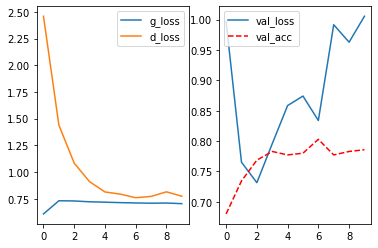

In [ ]:
#Training loss
ls_g_loss = []
ls_d_loss = []
ls_val_loss = []
ls_val_acc = []

for i in range(len(training_stats)):
    ls_g_loss.append(training_stats[i]['Training Loss generator'])
    ls_d_loss.append(training_stats[i]['Training Loss discriminator'])
    ls_val_loss.append(training_stats[i]['Valid. Loss'])
    ls_val_acc.append(training_stats[i]['Valid. Accur.'])
    
#Plotting
plt.subplot(1,2,1)
plt.plot(ls_g_loss, label='g_loss')
plt.plot(ls_d_loss, label='d_loss')
plt.legend(loc='upper right')
         
plt.subplot(1,2,2)
plt.plot(ls_val_loss, label='val_loss')
plt.plot(ls_val_acc, label='val_acc', color='red', linestyle='--')
plt.legend(loc='upper left')

# Making predictions

In [ ]:
# Load test dataset
df_target = pd.read_csv('Dataset4_test(ganbert)2.csv')
#df.columns = ['text', 'label']

# Show number of data entries
print('Number of data entries: {}'.format(len(df_target)))

# Mapping label to number
df_target['label'] = df_target['label'].map(class_map)

# label_mask
df_target['label_mask'] = df_target['label'].apply(generate_label_mask)

# Show a few samples
df_target.sample(3)

Number of data entries: 1300


,text,label,label_mask
82,You can't do that ! You can't charge me for a...,4,1
1053,"` I 'm so happy you could make it , my favouri...",5,1
306,Who is he ?,1,1


In [ ]:
# Convert df_target to dataloader
#t0 = time.time()

input_ids, attention_mask, labels, label_masks = encode_df(df_target)
input_ids, attention_mask, labels, label_masks = concat_data(input_ids, attention_mask, labels, label_masks)
target_dataloader = make_dataloader(input_ids, attention_mask, labels, label_masks, random_sampler=False)

#print('Tokenization took time: {}'.format(format_time(time.time()-t0)))

In [ ]:
prediction_stats = []

print("")
print("Running Prediction...")

t0 = time.time()

# Set models to eval mode
transformer.eval() 
discriminator.eval()
generator.eval()

# Tracking variables 
total_pred_accuracy = 0
total_pred_loss = 0

all_preds = []
all_labels_ids = []

#loss
nll_loss = torch.nn.CrossEntropyLoss(ignore_index=-1)

# Evaluate data for one epoch
for batch in target_dataloader:
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    with torch.no_grad():        
        model_outputs = transformer(b_input_ids, attention_mask=b_input_mask)
        hidden_states = model_outputs[-1]
        _, logits, probs = discriminator(hidden_states)
        ###log_probs = F.log_softmax(probs[:,1:], dim=-1)
        filtered_logits = logits[:,0:-1]
        # Accumulate the test loss.
        total_pred_loss += nll_loss(filtered_logits, b_labels)

    # Accumulate the predictions and the input labels
    _, preds = torch.max(filtered_logits, 1)
    all_preds += preds.detach().cpu()
    all_labels_ids += b_labels.detach().cpu()

# Report the final accuracy for this validation run.
all_preds = torch.stack(all_preds).numpy()
all_labels_ids = torch.stack(all_labels_ids).numpy()
pred_accuracy = np.sum(all_preds == all_labels_ids) / len(all_preds)
print("  Accuracy: {0:.3f}".format(pred_accuracy))

# Calculate the average loss over all of the batches.
avg_pred_loss = total_pred_loss / len(target_dataloader)
avg_pred_loss = avg_pred_loss.item()

# Measure how long the validation run took.
pred_time = format_time(time.time() - t0)

print("  Test Loss: {0:.3f}".format(avg_pred_loss))
print("  Test took: {:}".format(pred_time))

# Record all statistics from this epoch.
print('Show experimental settings: {}'.format(dict_settings))
print('\n')

prediction_stats.append(
    {
        'Prediction. Loss': avg_pred_loss,
        'prediction. Accur.': pred_accuracy,
        'Prediction Time': pred_time,
    }
)


Running Prediction...
  Accuracy: 0.752
  Test Loss: 1.209
  Test took: 0:00:10
Show experimental settings: {'labeled_data_size': 350, 'unlabeld_data_size': 350, 'num_train_epochs': 10}




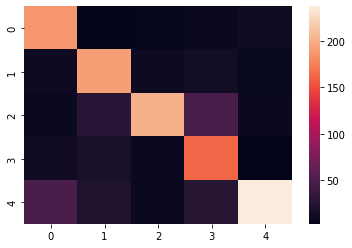

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report

# Confusion matrix
cm = confusion_matrix(all_preds, all_labels_ids)

sns.heatmap(cm)

In [ ]:
# Classification report
cr = classification_report(all_preds, all_labels_ids)

print(cr)

              precision    recall  f1-score   support

           1       0.69      0.86      0.77       216
           2       0.73      0.81      0.77       235
           3       0.85      0.68      0.75       297
           4       0.62      0.78      0.69       207
           5       0.87      0.69      0.77       345

    accuracy                           0.75      1300
   macro avg       0.75      0.76      0.75      1300
weighted avg       0.77      0.75      0.75      1300



# Time took for the entire noteobok

In [ ]:
time_diff = entire_notebook_t0 - time.time()
print('Time took for the entire notebook: {}'.format(time_diff))